# Декомпозиция галактик

Алгоритм. 

0) Необходим файл configN.imfit, который получается на раннем этапе (одномерная декомпозиция). N - какое-то число (2,3 и т.д.). Наверное, можно и самому его создать. Кроме того, необходимы файлы mask.fits (маскированные области, делается вручную через ds9 с конвертацией из ds9.reg в mask.fits при помощи скрипта regions2maskFits.py; в общем случае можно маскировать по-разному, поэтому в общем случае maskN.fits, где N - какое-то число), psf.fits (достаётся с Легаси), image.fits - "сырое" изображение.

1) Использование imfit.

imfit image.fits -c configN.imfit --loud --psf psf.fits --mask maskN.fits --ftol=1.0e-8 --save-params bestfitN.imfit --save-residual residualN.fits --mlr

(здесь N - какое-то число)
В результате создаются bestfitN.imfit (содержит параметры) и residualN.fits (остаточное изображение).

2) Использование makeimage.

makeimage bestfitN.imfit -o modelimageN.fits --refimage image.fits --psf psf.fits --output-functions comps_precN_

В результате создаются ...

makeimage bestfitN.imfit --refimage image.fits --save-fluxes fluxesN.dat

В результате создаётся файл fluxesN.dat с потоками компонент модели, в ноутбуке используется для вычисления отношений потоков.

3) Пропустить данный ноутбук. 
В результате создаются comps_precN*.fits (компоненты модели галактики) .

4) Перезаписать параметры из bestfitN.imfit в configN.imfit (чтобы ещё раз прогнать через imfit (т.е. начиная с пункта 1)) с помощью ноутбука parameters saver.ipynb.

5) Если всё устраивает, то на этом всё. Если модели подогнались не очень, то можно действовать так: 
а) перейти к пункту 1, поварьировав значения в configN.imfit и запустив imfit, дальше makeimage (первая половина пункта), пропускаем ноутбук, смотрим, если всё норм, то makeimage (вторая половина пункта) и ещё раз пропускаем ноутбук, чтобы отношения потоков правильные прописались, а если не всё норм, то перезаписываем параметры в config и делаем заново;
б) непосредственно работать с bestfitN.imfit (пункт 2), варьируя параметры, а дальше так же, как и в а). 

Здесь надо понять, что вычисление потоков через makeimage забирает немало времени, поэтому, чтоб вся работа шла быстрее, вычисление потоков оставляем на конец. 
В 5-ом пункте я бы предпочёл бы подпункт б), всё-таки imfit тоже время отбирает.


## imfit functions:

(используются в bestfitN.imfit)

FUNCTION DoubleBrokenExponential
PA
ell
I_0
h1
h2
h3
r_break1
r_break2

FUNCTION BrokenExponential2D
PA
I_0
h1
h2
r_break
alpha
h_z

FUNCTION BrokenExponential2
PA
ell
I_0
h1
h2
r_break

FUNCTION BrokenExponential
PA
ell
I_0
h1
h2
r_break
alpha

## parameters recalculation:

$$h_z = 2\times z_0$$

$$I_0 = J_0 \times 2 \times h_1 \times 0.262$$

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x7f78301d99c0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import shutil
import pandas as pd
import tabulate
import numpy as np
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.ndimage import rotate
from astropy.io import fits as pyfits

from astropy.visualization import ZScaleInterval
import imfittools.make_slice as ms
import imfittools.ImfitModel as imfitmod

In [3]:
 # Функция для того, чтобы сделать срезы вдоль х-структуры
def slice_x(img, fig, i, xcen,ycen,angle1,angle2,leng):
   
      # Повернём изображение на один угол для одного среза, потом на другой для другого
    resid1 = rotate(img, angle=np.degrees(angle1), reshape=False)
    resid2 = rotate(img, angle=np.degrees(angle2), reshape=False)
      # Поворот был осуществлён относительно центра кадра, найдём этот центр
    cent_img_y = img.shape[0] / 2
    cent_img_x = img.shape[1] / 2
      # Найдём координаты центра "повёрнутой" галактики
    cent_gal_xr1, cent_gal_yr1 = rotate_coords(xcen, ycen, cent_img_x, cent_img_y, -angle1)
    cent_gal_xr2, cent_gal_yr2 = rotate_coords(xcen, ycen, cent_img_x, cent_img_y, -angle2)
      # Переведём в int
    cent_gal_xr1 = int(cent_gal_xr1)
    cent_gal_xr2 = int(cent_gal_xr2)
    cent_gal_yr1 = int(cent_gal_yr1)
    cent_gal_yr2 = int(cent_gal_yr2)
      # Сделаем срезы
    x_slice1 = resid1[cent_gal_yr1, cent_gal_xr1-int(leng/2):cent_gal_xr1+int(leng/2)]
    x_slice2 = resid2[cent_gal_yr2, cent_gal_xr2-int(leng/2):cent_gal_xr2+int(leng/2)]
      # Найдём координаты концов срезов на исходном, "неповёрнутом" изображении
    x11, y11 = rotate_coords(cent_gal_xr1-leng/2, cent_gal_yr1, cent_img_x, cent_img_y, angle1)
    x12, y12 = rotate_coords(cent_gal_xr1+leng/2, cent_gal_yr1, cent_img_x, cent_img_y, angle1)
    x21, y21 = rotate_coords(cent_gal_xr2-leng/2, cent_gal_yr2, cent_img_x, cent_img_y, angle2)
    x22, y22 = rotate_coords(cent_gal_xr2+leng/2, cent_gal_yr2, cent_img_x, cent_img_y, angle2)
      # Нарисуем эти срезы на исходном изображении
    if i==0:
        plt.subplot(5, 2, i+1)
    else:
        plt.subplot(5, 2, i)
    plt.plot([x11, x12], [y11, y12], color = 'b')
    plt.plot([x21, x22], [y21, y22], color = 'orange')
      # Нарисуем сами срезы
    plt.subplot(5, 2, i+2)
    x_slice1 = resid1[cent_gal_yr1, cent_gal_xr1-int(leng/2):cent_gal_xr1+int(leng/2)]
    x_slice2 = resid2[cent_gal_yr2, cent_gal_xr2-int(leng/2):cent_gal_xr2+int(leng/2)]
    plt.plot(x_slice1, '.', color = 'b')
    plt.plot(x_slice2, '.', color = 'orange')
    plt.yscale('log')
    plt.title('Slices') 
 
 # Вспомогательная функция для slice_rotate()
def rotate_coords(x1, y1, xcen, ycen, angle):
    xrot = (x1 - xcen) * np.cos(angle) - (y1 - ycen) * np.sin(angle) + xcen
    yrot = (x1 - xcen) * np.sin(angle) + (y1 - ycen) * np.cos(angle) + ycen
    return xrot, yrot

# Получаем индекс галактики в voting_with_coords.csv, чтобы по индексу можно было получить ra,dec
def getind_gal(name_gal,df):
    for i in arange(1,df.shape[0]):
        if name_gal == df[0][i]:
            return i 
            break

In [4]:
file_all_gal = 'voting_with_coords.csv'
df_all_gal = pd.read_csv('../data/{}'.format(file_all_gal), header=None)

In [14]:
# Сводная таблица
# -------------------
# names = [[name,fold,n_bulges, i_2_bulges, i_1_bulge], [...], ...]
# где name - имя галактики fold - hexagons и т.д., i_2_bulges - итерация, на которой 2 балджа (если совсем
# не используются оба балджа, то поставить число 0, если используются, то самая последняя итерация), i_1_bulge -
# итерация, на которой использовался или до сих пор используется 1 балдж (во втором случае это самая последняя
# итерация)
names = [['1237_50_0_line1676__EON_21.856_-1.913','hexagons',5,2],['EON_150.398_-2.994','hexagons',4,2],
         ['732_72_0_line4676','iso_break',4,2],['1720_93_1_line10922','iso_break',5,3],['2015_16_1_line2021','iso_break',0,3],
         ['804_63_1_line2514','mass_bulge',0,4],['1354_49_0_line6745','mass_bulge',4,2],
         ['1640_74_0_line13441','mass_bulge',4,2],['EON_183.977_6.401','mass_bulge',6,4]]
#names = [['EON_183.977_6.401','mass_bulge',6,4]]
    

table_data = [['Name','chi2_base','chi2_imfit_b1','chi2_imfit_b2','BIC_b1','BIC_b2', 
          'B/T_b1','B/T_b2','B_cent/T_b2','Disk_b1','Disk_b2','D/T_b1','D/T_b2',
          'n_Sers_b1','n_Sers_b2','n_Sers_bcent_b2']]

for i in range(0,len(names)):
    path_raw = '../data/small_samp/{}/{}/image.fits'.format(names[i][1], names[i][0])
    hdulist_raw  = pyfits.open(path_raw)
    data_raw = hdulist_raw[0].data
    path_base_model = '../data/images/{}/{}/model_r_rotcrop.fits'.format(names[i][1], names[i][0])
    hdulist_base_model = pyfits.open(path_base_model)
    data_base_model = hdulist_base_model[0].data
    names_loc = os.listdir('../data/small_samp/{}/{}'.format(names[i][1], names[i][0]))
    for name in names_loc:
        if names[i][2] != 0:
            if name.find('comps_prec{}_2_'.format(names[i][2])) != -1:
                path_imfit_model_disk_2 = '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0],name)
                hdulist_imfit_model_disk_2  = pyfits.open(path_imfit_model_disk_2)
                data_imfit_model_disk_2 = hdulist_imfit_model_disk_2[0].data
            if name.find('comps_prec{}_Sersics'.format(names[i][2])) != -1:
                path_imfit_model_bulge_2 = '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0],name)
                hdulist_imfit_model_bulge_2  = pyfits.open(path_imfit_model_bulge_2)
                data_imfit_model_bulge_2 = hdulist_imfit_model_bulge_2[0].data  
        if name.find('comps_prec{}_2_'.format(names[i][3])) != -1:
            path_imfit_model_disk_1 = '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0],name)
            hdulist_imfit_model_disk_1  = pyfits.open(path_imfit_model_disk_1)
            data_imfit_model_disk_1 = hdulist_imfit_model_disk_1[0].data
        if name.find('comps_prec{}_1_Sersic'.format(names[i][3])) != -1:
            path_imfit_model_bulge_1 = '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0],name)
            hdulist_imfit_model_bulge_1  = pyfits.open(path_imfit_model_bulge_1)
            data_imfit_model_bulge_1 = hdulist_imfit_model_bulge_1[0].data     
    path_invvarmap = '../data/small_samp/{}/{}/invarmap/invvar_r_rotcrop.fits'.format(names[i][1], names[i][0])
    hdulist_invvarmap = pyfits.open(path_invvarmap)
    data_invvarmap = hdulist_invvarmap[0].data
    path_flux_b1 = '../data/small_samp/{}/{}/fluxes{}.dat'.format(names[i][1],names[i][0],names[i][3])
    path_bestfit_b1 = '../data/small_samp/{}/{}/bestfit{}.imfit'.format(names[i][1],names[i][0],names[i][3])
    path_bestfit_b2 = '../data/small_samp/{}/{}/bestfit{}.imfit'.format(names[i][1],names[i][0],names[i][2])
    
    path_mask_se0 = '../data/small_samp/{}/{}/mask_se.fits'.format(names[i][1],names[i][0])
    hdulist_mask_se0  = pyfits.open(path_mask_se0)
    mask_se0 = hdulist_mask_se0[0].data
    mask_se = np.ones_like(mask_se0)
    mask_se[mask_se0 == 1] *= 0 
    number_0 = 0
    for i_se in range(size(mask_se,0)):
        for j_se in range(size(mask_se,1)):
            if mask_se[i_se,j_se] == 0:
                number_0 += 1    
    data_base_model *= mask_se
    data_imfit_model_disk_1 *= mask_se 
    data_imfit_model_bulge_1 *= mask_se
    if names[i][2] != 0:
        data_imfit_model_disk_2 *= mask_se 
        data_imfit_model_bulge_2 *= mask_se
    data_raw *= mask_se 
    chi2_base = sum(data_invvarmap*(data_base_model - data_raw)**2)/(size(data_raw)-number_0)
    chi2_imfit_b1 = sum(data_invvarmap*(data_imfit_model_disk_1 + data_imfit_model_bulge_1 - data_raw)**2)/(size(data_raw)-number_0)
    chi2_imfit_b2 = None
    if names[i][2] != 0:
        chi2_imfit_b2 = sum(data_invvarmap*(data_imfit_model_disk_2 + data_imfit_model_bulge_2 - data_raw)**2)/(size(data_raw)-number_0)
        path_flux_b2 = '../data/small_samp/{}/{}/fluxes{}.dat'.format(names[i][1],names[i][0],names[i][2])
                
    sers1 = 0
    with open(path_flux_b1) as file:
        for l in file:
            if sers1 == 0:
                if l.find('Sersic') != -1:
                    bps_t_b1 = float(l.split()[3])
                    sers1 = 1
                    continue
                continue
            if sers1 == 1:
                disk1 = l.split()[0]
                if disk1.find('BknExp3D') != -1:
                    disk_type_b1 = 'BknExp3D'
                if disk1.find('ExponentialDisk3D') != -1:
                    disk_type_b1 = 'Exp3D'
                d_t_b1 = float(l.split()[3])
                sers1 = 2
                break 
    bps_t_b2 = None
    bc_t_b2 = None
    d_t_b2 = None
    disk_type_b2 = None
    if names[i][2] != 0:
        sers2 = 0
        with open(path_flux_b2) as file:
            for l in file:
                if sers2 == 0:
                    if l.find('Sersic') != -1:
                        bps_t_b2 = float(l.split()[3])
                        sers2 = 1
                        continue
                    continue
                if sers2 == 1:
                    disk2 = l.split()[0]
                    if disk2.find('BknExp3D') != -1:
                        disk_type_b2 = 'BknExp3D'
                    if disk2.find('ExponentialDisk3D') != -1:
                        disk_type_b2 = 'Exp3D'
                    d_t_b2 = float(l.split()[3])
                    sers2 = 2
                    continue
                if sers2 == 2:
                    if l.find('Sersic') != -1:
                        bc_t_b2 = float(l.split()[3])
                        sers2 = 3
                    break
    
    with open(path_bestfit_b1) as file:
        for line in file:
            if line.find('BIC') != -1:
                bic_b1 = float(line.split()[2])
            try:
                if line.split()[0] == 'n':
                    n_sersic_b1 = float(line.split()[1])
                    break
            except:
                continue
    n_sersic_bps_b2 = None
    n_sersic_bc_b2 = None
    bic_b2 = None
    if names[i][2] != 0:
        sersic_flag = 0
        with open(path_bestfit_b2) as file:
            for line in file:
                if line.find('BIC') != -1:
                    bic_b2 = float(line.split()[2])
                try:
                    if line.split()[0] == 'n':
                        sersic_flag += 1
                        if sersic_flag == 1:
                            n_sersic_bps_b2 = float(line.split()[1])
                        if sersic_flag == 3:
                            n_sersic_bc_b2 = float(line.split()[1])
                            break
                except:
                    continue
        
    chi2_base = float("{:.5f}".format(chi2_base))
    chi2_imfit_b1 = float("{:.5f}".format(chi2_imfit_b1))
    bic_b1 = float("{:.2f}".format(bic_b1))
    if names[i][2] != 0:
        chi2_imfit_b2 = float("{:.5f}".format(chi2_imfit_b2))
        bic_b2 = float("{:.2f}".format(bic_b2))
    table_data.append([names[i][0],chi2_base,chi2_imfit_b1,chi2_imfit_b2,bic_b1,bic_b2,bps_t_b1,bps_t_b2,bc_t_b2,
                  disk_type_b1,disk_type_b2,d_t_b1,d_t_b2,n_sersic_b1,n_sersic_bps_b2,n_sersic_bc_b2])
    
table = tabulate.tabulate(table_data, tablefmt='html')
print('chi2_base - хи-квадрат для вычета с Легаси')
print('chi2_imfit_b1 - хи-квадрат для нашего вычета (модель с одним балджем)')
print('chi2_imfit_b2 - хи-квадрат для нашего вычета (модель с двумя балджами)')
print('BIC_b1 - BIC для модели с одним балджем')
print('BIC_b2 - BIC для модели с двумя балджами')
print('B/T_b1 - отношение интенсивности балджа к общей (модель с одним балджем)')
print('B/T_b2 - отношение интенсивности большого неяркого балджа к общей (модель с двумя балджами)')
print('B_cent/T_b2 - отношение интенсивности маленького яркого балджа к общей (модель с двумя балджами)')
print('Disk_b1, Disk_b2 - тип диска (модель с одним и двумя балджами соответственно)')
print('D/T_b1, D/T_b2 - отношение интенс-ти диска к общей (модель с одним и двумя балджами соответственно)')
print('n_Sers_b1 - параметр Серсика (модель с одним балджем)')
print('n_Sers_b2 - параметр Серсика для большого неяркого балджа (модель с двумя балджами)')
print('n_Sers_bcent_b2 - параметр Серсика для маленького яркого балджа (модель с двумя балджами)')
print('-'*10)
print('Пустые позиции означают, что такой модели нет. Например, если нет модели с двумя балджами, то на')
print('позициях с _b2 будет пусто')
table 

chi2_base - хи-квадрат для вычета с Легаси
chi2_imfit_b1 - хи-квадрат для нашего вычета (модель с одним балджем)
chi2_imfit_b2 - хи-квадрат для нашего вычета (модель с двумя балджами)
BIC_b1 - BIC для модели с одним балджем
BIC_b2 - BIC для модели с двумя балджами
B/T_b1 - отношение интенсивности балджа к общей (модель с одним балджем)
B/T_b2 - отношение интенсивности большого неяркого балджа к общей (модель с двумя балджами)
B_cent/T_b2 - отношение интенсивности маленького яркого балджа к общей (модель с двумя балджами)
Disk_b1, Disk_b2 - тип диска (модель с одним и двумя балджами соответственно)
D/T_b1, D/T_b2 - отношение интенс-ти диска к общей (модель с одним и двумя балджами соответственно)
n_Sers_b1 - параметр Серсика (модель с одним балджем)
n_Sers_b2 - параметр Серсика для большого неяркого балджа (модель с двумя балджами)
n_Sers_bcent_b2 - параметр Серсика для маленького яркого балджа (модель с двумя балджами)
----------
Пустые позиции означают, что такой модели нет. Например,

Name,chi2_base,chi2_imfit_b1,chi2_imfit_b2,BIC_b1,BIC_b2,B/T_b1,B/T_b2,B_cent/T_b2,Disk_b1,Disk_b2,D/T_b1,D/T_b2,n_Sers_b1,n_Sers_b2,n_Sers_bcent_b2
1237_50_0_line1676__EON_21.856_-1.913,99.80282,63.99504,68.16914,2798767.24,1378930.02,0.61129,0.31205,0.2441,BknExp3D,BknExp3D,0.38871,0.44385,3.05324,1.0,1.42914
EON_150.398_-2.994,22.95572,10.90551,9.99958,192060.44,174561.93,0.39745,0.31225,0.13983,BknExp3D,BknExp3D,0.60255,0.54792,2.03883,1.0,4.80045
732_72_0_line4676,56.96899,31.67047,36.18641,262235.65,179796.12,0.41452,0.21984,0.13052,BknExp3D,BknExp3D,0.58548,0.64964,2.50032,1.0,4.5
1720_93_1_line10922,22.60552,37.11405,29.00478,378204.04,415879.29,0.68041,0.30187,0.03871,Exp3D,Exp3D,0.31959,0.65942,3.02081,1.0,2.61763
2015_16_1_line2021,8.91346,7.21885,,50338.83,,0.45452,,,BknExp3D,,0.54548,,1.98086,,
804_63_1_line2514,1100.85766,5.82467,,29727.63,,0.21218,,,Exp3D,,0.78782,,0.735094,,
1354_49_0_line6745,41.83431,34.62199,24.86964,554239.83,507376.37,0.52827,0.27934,0.12134,BknExp3D,BknExp3D,0.47173,0.59932,1.98977,1.0,8.0
1640_74_0_line13441,15.22075,3.37506,6.00302,33297.76,37229.24,0.56206,0.06905,0.49182,BknExp3D,BknExp3D,0.43794,0.43914,2.9098,1.0,2.43608
EON_183.977_6.401,43.06609,21.08791,14.01552,1363251.6,1103722.66,0.62962,0.34592,0.10603,Exp3D,Exp3D,0.37038,0.54805,5.67,6.03833,1.1809


=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
mass_bulge
EON_183.977_6.401
 
Simbad:
http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=183.977234d6.4011510000000005d&CooFrame=ICRS&CooEpoch=2000&CooEqui=2000&Radius=0.5&Radius.unit=arcmin&submit=submit+query&CoordList=
NED:
https://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates=183.977234d%20%2B6.401151d&radius=0.2&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Equatorial&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center
Legacy:
https://www.legacysurvey.org/viewer/?ra=183.977234&dec=6.4011510000000005&layer=ls-dr9&zoom=13


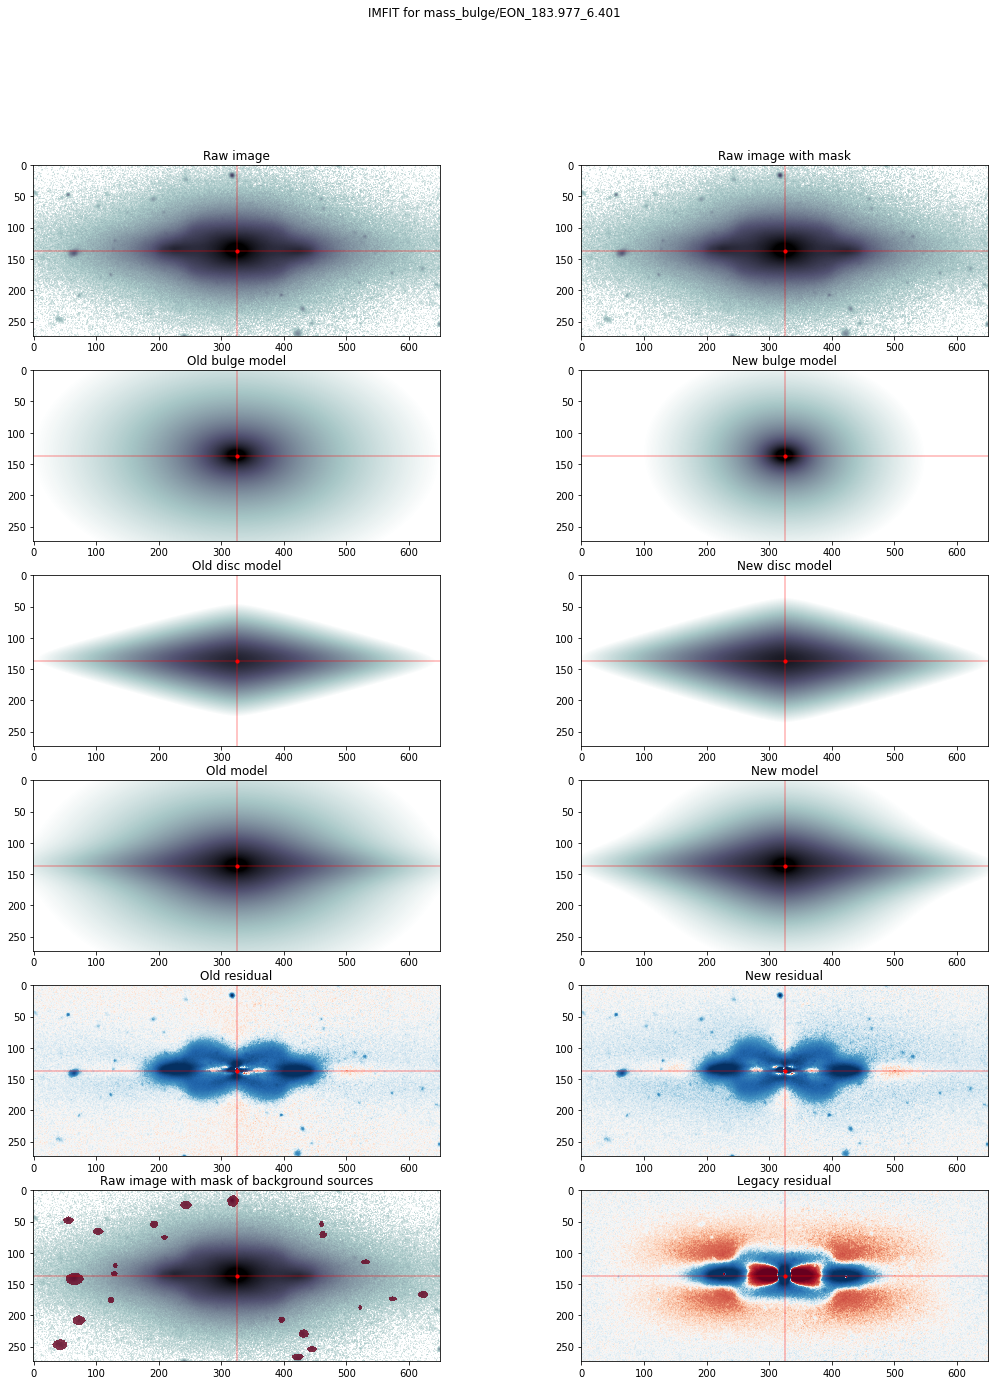

                                    ------------------------------
                                                  New
Reading '../data/small_samp/mass_bulge/EON_183.977_6.401/bestfit6.imfit':
  3 functions found (22 parameters)

Biggest component of a model is ExponentialDisk3D.1
It's coordinates 325.4,136.3.
It's position angle 90.4766
Making model


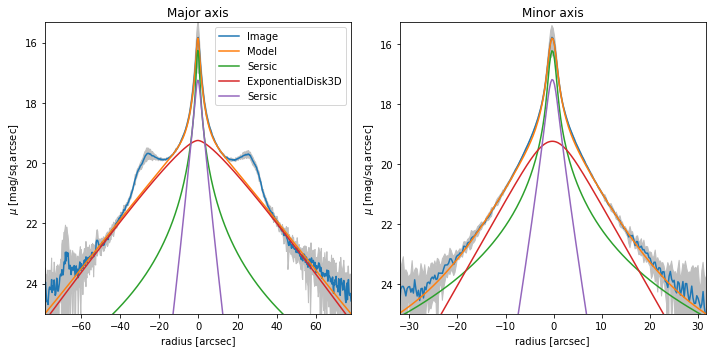

                                    ------------------------------
                                                  Old
Reading '../data/small_samp/mass_bulge/EON_183.977_6.401/bestfit5.imfit':
  3 functions found (22 parameters)

Biggest component of a model is ExponentialDisk3D.1
It's coordinates 325.5,136.3.
It's position angle 90.3329
Making model


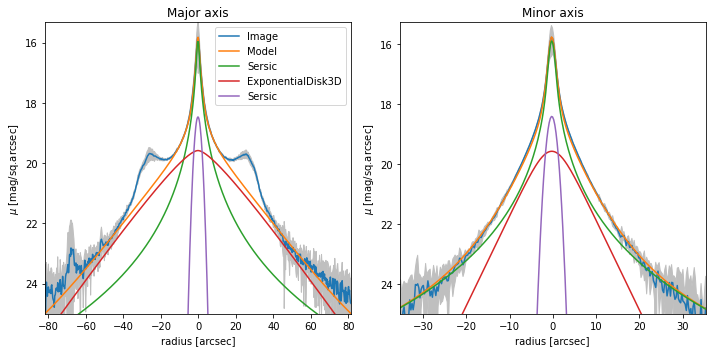

           ----------------------------------------------------------------------
           Old                                               New
                                         Bestfit:
#   Best-fit value: 1117346.893832                  #   Best-fit value: 1103541.361196
#   Reduced value: 6.297183                         #   Reduced value: 6.219412
#   AIC: 1117374.896199                             #   AIC: 1103571.363902
#   BIC: 1117516.104051                             #   BIC: 1103722.657859
                                                    
X0		325.5000 # +/- 0.0000                           X0		325.3800 # +/- 0.0000
Y0		136.3180 # +/- 0.0000                           Y0		136.3170 # +/- 0.0000
FUNCTION Sersic                                     FUNCTION Sersic
PA		90.7964 # +/- 0.057116                          PA		92.778 # +/- 0.11954
ell		0.409581 # +/- 0.00068767                      ell		0.293548 # +/- 0.0012663
n		5.27716 # +/- 0.013213                       

In [15]:
### Завершено: '1237_50_0_line1676__EON_21.856_-1.913' 'EON_150.398_-2.994','732_72_0_line4676',
#'2015_16_1_line2021', '1720_93_1_line10922', '804_63_1_line2514', '1354_49_0_line6745', '1640_74_0_line13441'
               
#dirs = ['hexagons', 'mass_bulge']
dirs = ['mass_bulge']
#num_in_dir = [1,3]
num_in_dir = [1]
#names = ['1237_50_0_line1676__EON_21.856_-1.913', 
#         '804_63_1_line2514','1640_74_0_line13441','EON_183.977_6.401']
names = ['EON_183.977_6.401']

N_old = [5] #[4,3,3,5]
N_new = [6] #[5,4,4,6]
    
i0 = 0
ii = 0
for index in range(len(dirs)):
    set_name = dirs[index]
    for indd in range(num_in_dir[i0]):
        i = names[ii]
        #ii += 1
        print('=*'*50)
        print(set_name)
        print(i)
        
            # Дадим некоторые ссылки на галактику
        ind_gal = getind_gal(i,df_all_gal)
        ra = float(df_all_gal[1][ind_gal])
        dec = float(df_all_gal[2][ind_gal])
        url_simbad = "http://simbad.u-strasbg.fr/simbad/sim-coo?Coord={}d{}d&CooFrame=ICRS&CooEpoch=2000&CooEqui=2000&Radius=0.5&Radius.unit=arcmin&submit=submit+query&CoordList=".format(ra,dec)
        ra_ned = round(ra, 10)
        dec_ned = round(dec, 10)
        if dec>0.0:
            url_ned = "https://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates={}d%20%2B{}d&radius=0.2&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Equatorial&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center".format(ra_ned,dec_ned)
        else:
            url_ned = "https://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates={}d%20{}d&radius=0.2&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Equatorial&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center".format(ra_ned,dec_ned)

        url_legacy = "https://www.legacysurvey.org/viewer/?ra={}&dec={}&layer=ls-dr9&zoom=13".format(ra,dec)
        print(" ")
        print("Simbad:")
        print(url_simbad)
        print("NED:")
        print(url_ned)
        print("Legacy:")
        print(url_legacy)
            
            # Разберёмся со всеми путями -------------------
        path_config_old = '../data/small_samp/{}/{}/config{}.imfit'.format(set_name, i, N_old[ii])
        path_config_new = '../data/small_samp/{}/{}/config{}.imfit'.format(set_name, i, N_new[ii])
        path_imfit_old = '../data/small_samp/{}/{}/bestfit{}.imfit'.format(set_name, i, N_old[ii])
        path_imfit_new = '../data/small_samp/{}/{}/bestfit{}.imfit'.format(set_name, i, N_new[ii])
        path_flux_old = '../data/small_samp/{}/{}/fluxes{}.dat'.format(set_name, i, N_old[ii])
        path_flux_new = '../data/small_samp/{}/{}/fluxes{}.dat'.format(set_name, i, N_new[ii])
        path_psf = '../data/small_samp/{}/{}/psf.fits'.format(set_name, i)
        path_mask_old = '../data/small_samp/{}/{}/mask{}.fits'.format(set_name, i, N_old[ii])
        path_mask_new = '../data/small_samp/{}/{}/mask{}.fits'.format(set_name, i, N_new[ii])
        path_mask_se = '../data/small_samp/{}/{}/mask_se.fits'.format(set_name, i)
        path_raw = '../data/small_samp/{}/{}/image.fits'.format(set_name, i)
        #path_model_base = '../data/images/{}/{}/model_r_rotcrop.fits'.format(set_name, i)
        path_resid_base = '../data/images/{}/{}/residual_r_rotcrop.fits'.format(set_name, i)
        path_model_old = '../data/small_samp/{}/{}/modelimage{}.fits'.format(set_name, i, N_old[ii])
        path_resid_old = '../data/small_samp/{}/{}/residual{}.fits'.format(set_name, i, N_old[ii])
        path_model_new = '../data/small_samp/{}/{}/modelimage{}.fits'.format(set_name, i, N_new[ii])
        path_resid_new = '../data/small_samp/{}/{}/residual{}.fits'.format(set_name, i, N_new[ii])       
        path_bulge_model_old = '../data/small_samp/{}/{}/comps_prec{}_Sersics.fits'.format(set_name, i, N_old[ii])
        path_bulge_model_new = '../data/small_samp/{}/{}/comps_prec{}_Sersics.fits'.format(set_name, i, N_new[ii])
        path_bulge_bps_model_old = '../data/small_samp/{}/{}/comps_prec{}_1_Sersic.fits'.format(set_name, i, N_old[ii])
        path_bulge_bps_model_new = '../data/small_samp/{}/{}/comps_prec{}_1_Sersic.fits'.format(set_name, i, N_new[ii])
        hdulist_bulge_bps_model_old  = pyfits.open(path_bulge_bps_model_old)
        data_bulge_bps_model_old = hdulist_bulge_bps_model_old[0].data
        hdulist_bulge_bps_model_new  = pyfits.open(path_bulge_bps_model_new)
        data_bulge_bps_model_new = hdulist_bulge_bps_model_new[0].data
        data_bulge_model_old = data_bulge_bps_model_old
        data_bulge_model_new = data_bulge_bps_model_new       
        names_loc = os.listdir('../data/small_samp/{}/{}'.format(set_name, i))
        for name in names_loc:
            if name.find('comps_prec{}_3_Sersic'.format(N_old[ii])) != -1:
                path_bulge_cent_model_old =  '../data/small_samp/{}/{}/{}'.format(set_name, i, name)
                hdulist_bulge_cent_model_old  = pyfits.open(path_bulge_cent_model_old)
                data_bulge_cent_model_old = hdulist_bulge_cent_model_old[0].data
                data_bulge_model_old = data_bulge_model_old + data_bulge_cent_model_old
                hdu = pyfits.PrimaryHDU(data=data_bulge_model_old) 
                hdu.writeto(path_bulge_model_old, overwrite=True)
            if name.find('comps_prec{}_3_Sersic'.format(N_new[ii])) != -1:
                path_bulge_cent_model_new =  '../data/small_samp/{}/{}/{}'.format(set_name, i, name)
                hdulist_bulge_cent_model_new  = pyfits.open(path_bulge_cent_model_new)
                data_bulge_cent_model_new = hdulist_bulge_cent_model_new[0].data
                data_bulge_model_new = data_bulge_model_new + data_bulge_cent_model_new
                hdu = pyfits.PrimaryHDU(data=data_bulge_model_new) 
                hdu.writeto(path_bulge_model_new, overwrite=True)
            if name.find('comps_prec{}_2_'.format(N_old[ii])) != -1:
                path_disc_model_old = '../data/small_samp/{}/{}/{}'.format(set_name, i, name)
                hdulist_disc_model_old  = pyfits.open(path_disc_model_old)
                data_disc_model_old = hdulist_disc_model_old[0].data
            if name.find('comps_prec{}_2_'.format(N_new[ii])) != -1:
                path_disc_model_new = '../data/small_samp/{}/{}/{}'.format(set_name, i, name)
                hdulist_disc_model_new  = pyfits.open(path_disc_model_new)
                data_disc_model_new = hdulist_disc_model_new[0].data
        path_pic = '../data/small_samp/{}/{}/picture{}.png'.format(set_name, i, N_new[ii])
        path_slice_x = '../data/small_samp/{}/{}/slice_x_{}.png'.format(set_name, i, N_old[ii])
        path_slice_old = '../data/small_samp/{}/{}/slice{}.png'.format(set_name, i, N_old[ii])
        path_slice_new = '../data/small_samp/{}/{}/slice{}.png'.format(set_name, i, N_new[ii])
        path_raw_minus_disc_old = '../data/small_samp/{}/{}/image_minus_disc_{}.fits'.format(set_name, i, N_old[ii])
        path_raw_minus_disc_new = '../data/small_samp/{}/{}/image_minus_disc_{}.fits'.format(set_name, i, N_new[ii])
        
            # Считаем координаты центра из bestfit'а
        with open(path_imfit_old) as file:
            for line in file:
                if line.find('X0') != -1:
                    XCEN_old = float(line.split()[1])
                if line.find('Y0') != -1:
                    YCEN_old = float(line.split()[1])
        with open(path_imfit_new) as file:
            for line in file:
                if line.find('X0') != -1:
                    XCEN_new = float(line.split()[1])
                if line.find('Y0') != -1:
                    YCEN_new = float(line.split()[1])
            
            # Прочитаем соответствующие фитсы
        hdulist_raw  = pyfits.open(path_raw)
        data_raw = hdulist_raw[0].data
        hdulist_resid_base = pyfits.open(path_resid_base)
        data_resid_base = hdulist_resid_base[0].data
                # Вычитаем из оригинала модель диска, сохраняем
        data_minus_disc_old = data_raw - data_disc_model_old
        data_minus_disc_new = data_raw - data_disc_model_new
        hdulist_minus_disc_old = pyfits.PrimaryHDU(data=data_minus_disc_old) 
        hdulist_minus_disc_old.writeto(path_raw_minus_disc_old, overwrite=True)
        hdulist_minus_disc_new = pyfits.PrimaryHDU(data=data_minus_disc_new) 
        hdulist_minus_disc_new.writeto(path_raw_minus_disc_new, overwrite=True)

        hdulist_model_old  = pyfits.open(path_model_old)
        data_model_old = hdulist_model_old[0].data
    
        hdulist_resid_old  = pyfits.open(path_resid_old)
        data_resid_old = hdulist_resid_old[0].data

        hdulist_model_new  = pyfits.open(path_model_new)
        data_model_new = hdulist_model_new[0].data
            
        data_resid_new = data_raw - data_model_new
        hdu = pyfits.PrimaryHDU(data=data_resid_new) 
        hdu.writeto(path_resid_new, overwrite=True)
        

            # Начнём рисовать
        fig = plt.figure(figsize=[18,22])
        
        plt.subplot(6, 2, 1)                    
        plt.imshow(data_raw, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('Raw image')
        
        hdulist_mask_new  = pyfits.open(path_mask_new)
        mask_new = hdulist_mask_new[0].data
        mask_new_to_show = np.zeros_like(mask_new)
        mask_new_to_show[mask_new == 0] *= np.nan
        plt.subplot(6, 2, 2)                    
        plt.imshow(data_raw, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.imshow(mask_new_to_show, alpha=0.8, cmap=cm.RdBu) # Рисуется маска 
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('Raw image with mask')
        
        plt.subplot(6, 2, 3) 
        plt.imshow(data_bulge_model_old, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_old,YCEN_old, 10, color='r')
        plt.axvline(x=XCEN_old,color='r', alpha=0.3)
        plt.axhline(y=YCEN_old,color='r', alpha=0.3)
        plt.title('Old bulge model')
        
        plt.subplot(6, 2, 4) 
        plt.imshow(data_bulge_model_new, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('New bulge model')
        
        plt.subplot(6, 2, 5) 
        plt.imshow(data_disc_model_old, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_old,YCEN_old, 10, color='r')
        plt.axvline(x=XCEN_old,color='r', alpha=0.3)
        plt.axhline(y=YCEN_old,color='r', alpha=0.3)
        plt.title('Old disc model')
        
        plt.subplot(6, 2, 6) 
        plt.imshow(data_disc_model_new, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('New disc model')
        
        plt.subplot(6, 2, 7)  
        plt.imshow(data_model_old, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_old,YCEN_old, 10, color='r')
        plt.axvline(x=XCEN_old,color='r', alpha=0.3)
        plt.axhline(y=YCEN_old,color='r', alpha=0.3)
        plt.title('Old model')

        plt.subplot(6, 2, 8)
        plt.imshow(data_model_new, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('New model')
        
        plt.subplot(6, 2, 9) 
        plt.imshow(data_resid_old, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.scatter(XCEN_old,YCEN_old, 10, color='r')
        plt.axvline(x=XCEN_old,color='r', alpha=0.3)
        plt.axhline(y=YCEN_old,color='r', alpha=0.3)
        plt.title('Old residual')
        
        plt.subplot(6, 2, 10)
        plt.imshow(data_resid_new, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu) 
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('New residual')
        
        hdulist_mask_se  = pyfits.open(path_mask_se)
        mask_se = hdulist_mask_se[0].data
        mask_se_to_show = np.zeros_like(mask_se)
        mask_se_to_show[mask_se == 0] *= np.nan
        plt.subplot(6, 2, 11)                    
        plt.imshow(data_raw, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.imshow(mask_se_to_show, alpha=0.8, cmap=cm.RdBu) # Рисуется маска 
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('Raw image with mask of background sources')
        
        plt.subplot(6, 2, 12)
        plt.imshow(data_resid_base, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.scatter(XCEN_new,YCEN_new, 10, color='r')
        plt.axvline(x=XCEN_new,color='r', alpha=0.3)
        plt.axhline(y=YCEN_new,color='r', alpha=0.3)
        plt.title('Legacy residual')

        plt.savefig(path_pic,bbox_inches = 'tight', pad_inches = 0.1)#,dpi=400)
        
        plt.suptitle(f'IMFIT for {set_name}/{i}')
        
        plt.show()

           # Теперь сделаем горизонтальный и вертикальный срезы, нарисуем
        magzpt = 22.5
        image_scale = 0.262
        
        print("%s %s" %(' '*35, '-'*30))
        print("%sNew" %(' '*50))
        ms.make_slice(path_raw, path_imfit_new, magzpt = magzpt, scale = image_scale, psf = path_psf, mask = path_mask_new, outname = path_slice_new)
        plt.show()
        print("%s %s" %(' '*35, '-'*30))
        print("%sOld" %(' '*50))
        ms.make_slice(path_raw, path_imfit_old, magzpt = magzpt, scale = image_scale, psf = path_psf, mask = path_mask_old, outname = path_slice_old)
        plt.show()
        
           # Рисунки нарисовали, теперь надо вывести параметры из файлов
        with open(path_imfit_old, 'r') as bfo:
            bfo_lines = bfo.readlines()[7:]
        with open(path_imfit_new, 'r') as bfn:
            bfn_lines = bfn.readlines()[7:]
        with open(path_config_old, 'r') as cfo:
            cfo_lines = cfo.readlines()
        with open(path_config_new, 'r') as cfn:
            cfn_lines = cfn.readlines()
        print("%s %s" %(' '*10, '-'*70))
        print("%s Old %s New" %(' '*10, ' '*45))
        print("%s Bestfit:" %(' '*40))
        mbf = []
        mbf.append(len(bfo_lines))
        mbf.append(len(bfn_lines))
        for l in range(max(mbf)):
            try:
                lengb = len(bfo_lines[l][:-1])
                print("%s %s %s" %(bfo_lines[l][:-1], ' '*(50-lengb), bfn_lines[l][:-1]))
            except:
                if mbf[0] == max(mbf):
                    print("%s" %(bfo_lines[l][:-1]))
                if mbf[1] == max(mbf):
                    print("%s %s" %(' '*50, bfn_lines[l][:-1]))
        print("%s Config:" %(' '*40))
        mcf = []
        mcf.append(len(cfo_lines))
        mcf.append(len(cfn_lines))
        for l in range(max(mcf)):
            try:
                lengc = len(cfo_lines[l][:-1])
                print("%s %s %s" %(cfo_lines[l][:-1], ' '*(50-lengc), cfn_lines[l][:-1]))
            except:
                if mcf[0] == max(mcf):
                    print("%s" %(cfo_lines[l][:-1]))
                if mcf[1] == max(mcf):
                    print("%s %s" %(' '*50, cfn_lines[l][:-1]))
                    
           # Параметры выведены. Теперь выведем отношение потоков компонентов моделей к суммарному потоку
         
           # Ноутбук будет дольше работать, проще в терминале запустить makeimage ... --save-fluxes, а потом 
           # из файла считать нужные отношения.
        #imf_class = imfitmod.ImfitModel(path_imfit_new)   # Т.е можно всё это организовать сразу в ноутбуке,
        #fluxes = imf_class.get_relative_fluxes()          # но тогда ноутбук будет дольше работать
        #print("Bulge(B/PS) / Total = %s" %(fluxes[0]))
        #print("Disk / Total = %s" %(fluxes[1]))
        #print("Bulge(central) / Total = %s" %(fluxes[2]))
    
        print("%s %s" %(' '*10, '-'*70))
        print("%s Old %s New" %(' '*15, ' '*45))
        print("%s Relative fluxes:" %(' '*30))
        sers1_old = 0
        with open(path_flux_old) as file:
            for l in file:
                if sers1_old == 0:
                    if l.find('Sersic') != -1:
                        bps_total_old = float(l.split()[3])
                        sers1_old = 1
                        continue
                    continue
                if sers1_old == 1:
                    disk_total_old = float(l.split()[3])
                    sers1_old = 2
                    continue
                if sers1_old == 2:
                    if l.find('Sersic') != -1:
                        cent_total_old = float(l.split()[3])
                        sers1_old = 3
                    break
        sers1_new = 0
        with open(path_flux_new) as file:
                for l in file:
                    if sers1_new == 0:
                        if l.find('Sersic') != -1:
                            bps_total_new = float(l.split()[3])
                            sers1_new = 1
                            continue
                        continue
                    if sers1_new == 1:
                        disk_total_new = float(l.split()[3])
                        sers1_new = 2
                        continue
                    if sers1_new == 2:
                        if l.find('Sersic') != -1:
                            cent_total_new = float(l.split()[3])
                            sers1_new = 3
                        break
        print("Bulge / Total = %s %s Bulge / Total = %s" %(bps_total_old, ' '*(17-len(str(bps_total_old))), bps_total_new))
        print("Disk / Total = %s %s Disk / Total = %s" %(disk_total_old, ' '*(24-len(str(disk_total_old))), disk_total_new))
        if sers1_old > sers1_new:
            print("Bulge(central) / Total = %s" %(cent_total_old))
        if sers1_old < sers1_new:
            print("%s Bulge(central) / Total = %s" %(' '*40, cent_total_new))
        if sers1_old == 3 and sers1_new == 3:
            print("Bulge(central) / Total = %s %s Bulge(central) / Total = %s" %(cent_total_old, ' '*(14-len(str(cent_total_old))), cent_total_new))              
        ii += 1
    i0 += 1
                

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
mass_bulge
EON_183.977_6.401


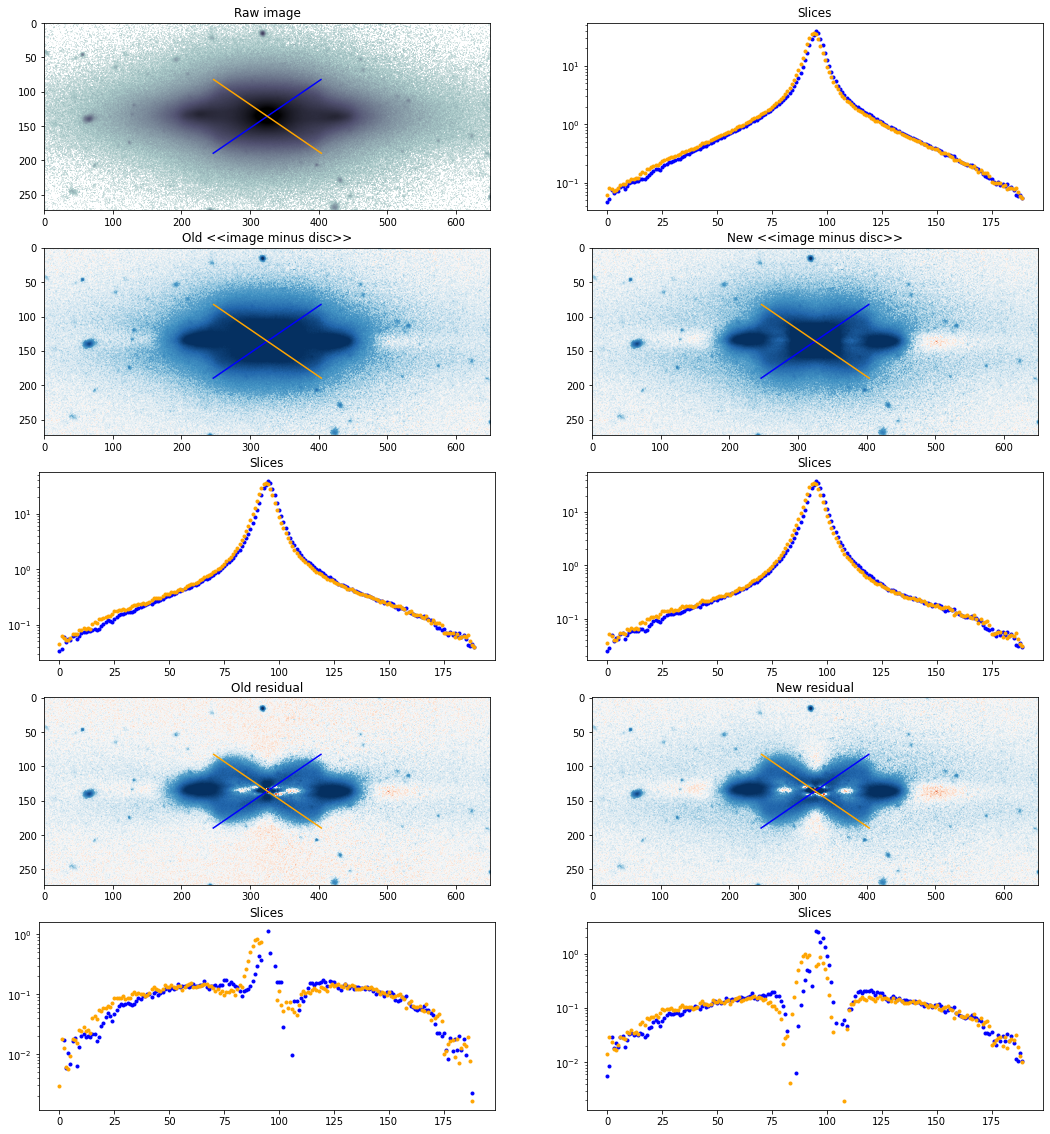

In [16]:
 # Решил срезы вдоль х-лучей вывести в отдельной ячейке

### Завершено: '1237_50_0_line1676__EON_21.856_-1.913' 'EON_150.398_-2.994','732_72_0_line4676',
#'2015_16_1_line2021', '1720_93_1_line10922', '804_63_1_line2514', '1354_49_0_line6745', '1640_74_0_line13441'
    
#dirs = ['hexagons','mass_bulge']
dirs = ['mass_bulge']
#num_in_dir = [1,3]
num_in_dir = [1]
#names = ['1237_50_0_line1676__EON_21.856_-1.913', 
#         '804_63_1_line2514','1640_74_0_line13441','EON_183.977_6.401']
names = ['EON_183.977_6.401']
    
    # Теперь вводятся не координаты концов срезов, а координаты центра галактики, угол наклона каждого среза 
    # и длина срезов.
     # Надо учесть: 1) длина каждого среза должна быть одинаковой, причём так, чтобы центр каждого среза приходился
     #               на центр галактики (объясняется тем, что питон при построении рисунка срезов совмещает на нём
     #                                   начала срезов)
     #              2) очень желательна симметрия х-структуры относительно центра
     #              3) очень желательно чтобы х-структура была прямолинейной (а не искривлённой)
     #   Последние два пункта объясняются тем, что сами срезы - прямые линии, проходящие через центр галактики.
     #   В дальнейшем можно усложнять: например, находить максимумы х-структры, примерно по ним проводить срез
     #                                (криволинейный срез? И если это будет представлять интерес)
cent_gal_x = [325.500] #[259,92.07,97.7,325.500] #228.4487
cent_gal_y = [136.3180] #[80.1,33.99,47.0,136.3180] #99.2844
angle1 = [-0.60] #[-0.607306,-0.60,-0.50,-0.60]
angle2 = [0.60] #[0.607306,0.60,0.50,0.60]
leng = [190] #[100,30,60,190]

N_old = [5] #[4,3,3,5] 
N_new = [6] #[5,4,4,6] 

i0 = 0
ii = 0
for index in range(len(dirs)):
    set_name = dirs[index]
    for indd in range(num_in_dir[i0]):
        i = names[ii]
        print('=*'*50)
        print(set_name)
        print(i)
           
            # Пути
        path_raw = '../data/small_samp/{}/{}/image.fits'.format(set_name, i)
        path_raw_minus_disc_old = '../data/small_samp/{}/{}/image_minus_disc_{}.fits'.format(set_name, i, N_old[ii])
        path_raw_minus_disc_new = '../data/small_samp/{}/{}/image_minus_disc_{}.fits'.format(set_name, i, N_new[ii])
        path_resid_old = '../data/small_samp/{}/{}/residual{}.fits'.format(set_name, i, N_old[ii])
        path_resid_new = '../data/small_samp/{}/{}/residual{}.fits'.format(set_name, i, N_new[ii])
        path_slice_x_new = '../data/small_samp/{}/{}/slice_x_{}.png'.format(set_name, i, N_new[ii])
                      
            # Открытие файлов
        hdulist_raw  = pyfits.open(path_raw)
        data_raw = hdulist_raw[0].data
        hdulist_minus_disc_old = pyfits.open(path_raw_minus_disc_old) 
        data_minus_disc_old = hdulist_minus_disc_old[0].data
        hdulist_minus_disc_new = pyfits.open(path_raw_minus_disc_new) 
        data_minus_disc_new = hdulist_minus_disc_new[0].data
        hdulist_resid_old  = pyfits.open(path_resid_old)
        data_resid_old = hdulist_resid_old[0].data
        hdulist_resid_new  = pyfits.open(path_resid_new)
        data_resid_new = hdulist_resid_new[0].data
                
        fig = plt.figure(figsize=[18,20])
        
        plt.subplot(5, 2, 1)
        plt.imshow(data_raw, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.title('Raw image')  
        slice_x(data_raw, fig, 0, cent_gal_x[ii], cent_gal_y[ii], angle1[ii], angle2[ii], leng[ii])
        
        plt.subplot(5, 2, 3)
        plt.imshow(data_minus_disc_old, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.title('Old <<image minus disc>>')  
        slice_x(data_minus_disc_old, fig, 3, cent_gal_x[ii], cent_gal_y[ii], angle1[ii], angle2[ii], leng[ii])
        
        plt.subplot(5, 2, 4)
        plt.imshow(data_minus_disc_new, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.title('New <<image minus disc>>')  
        slice_x(data_minus_disc_new, fig, 4, cent_gal_x[ii], cent_gal_y[ii], angle1[ii], angle2[ii], leng[ii])
                      
        plt.subplot(5, 2, 7)
        plt.imshow(data_resid_old, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.title('Old residual')  
        slice_x(data_resid_old, fig, 7, cent_gal_x[ii], cent_gal_y[ii], angle1[ii], angle2[ii], leng[ii])
        
        plt.subplot(5, 2, 8)
        plt.imshow(data_resid_new, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.title('New residual')  
        slice_x(data_resid_new, fig, 8, cent_gal_x[ii], cent_gal_y[ii], angle1[ii], angle2[ii], leng[ii]) 
        
        plt.savefig(path_slice_x_new,bbox_inches = 'tight', pad_inches = 0.1)#,dpi=400)
        
        plt.show()
        ii += 1
    i0 += 1